# <font color="#114b98">Catégorisez automatiquement des questions</font>

## <font color="#114b98">Notebook de test de différents modèles</font>

**Stack Overflow** est un site célèbre de questions-réponses liées au développement informatique.

L'objectif de ce projet est de développer un système de **suggestion de tags** pour ce site. Celui-ci prendra la forme d’un algorithme de machine learning qui assignera automatiquement plusieurs tags pertinents à une question.

**Livrable** : Un notebook de test de différents modèles

**Objectifs** : Comparer les modèles et générer des tags pour chacun d'entre eux

## <font color="#114b98">Sommaire</font>
[1. Chargement du jeu de données](#section_1)

[2. Approche non supervisée](#section_2)

[3. Approche supervisée](#section_3)

[4. Approche supervisée avec Word Embedding : Word2Vec](#section_4)

[5. Approche supervisée avec Word Embedding : BERT](#section_5)

[6. Approche supervisée avec Sentence Embedding : USE](#section_6)

[7. Choix du modèle pour le code final à déployer](#section_7)

## <font color="#114b98" id="section_1">1. Chargement du jeu de données</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import ast
import random
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
plt.rc('axes', titlesize=22) 
plt.rc('axes', labelsize=18) 
titleprops = {'fontsize':20}
textprops = {'fontsize':15}
plt.style.use('ggplot')

In [4]:
main_path = 'N:/5 - WORK/1 - Projets/Projet 5/'
files = os.listdir(main_path+'saved_ressources/')
files

['data_cleaned.csv', 'data_cleaned_wo_tokenizer.csv', 'model.h5']

In [5]:
data = pd.read_csv(main_path+'saved_ressources/'+'data_cleaned.csv', encoding='utf8')

In [6]:
data = data.applymap(lambda x: ast.literal_eval(x))

In [7]:
data.head()

,Tags,Texts
0,"[macos, emacs, scheme, interpreter, sicp]","[scheme, interpreter, interpreter, python, int..."
1,"[c#, functional-programming, delegates, lambda...","[scope, bug, compiler, voidfunction, delegate,..."
2,"[mysql, database, arrays, postgresql, stored-p...","[pass, array, procedure, pass, array, procedur..."
3,"[ios, objective-c, iphone, cocoa-touch, uibutton]","[state, buttonwithtype, figure, button, state,..."
4,"[database, nhibernate, exception-handling, con...","[check, application, column, constraint, colum..."


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159599 entries, 0 to 159598
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Tags    159599 non-null  object
 1   Texts   159599 non-null  object
dtypes: object(2)
memory usage: 2.4+ MB


Le jeu de données est trop important pour les temps de calculs à ma disposition.

J'ai deux possibilités : 
- prendre un sample d'observations aléatoirement
- prendre les observations pour lesquelles la similarité entre les deux colonnes est importante

In [9]:
# data_sample = data.sample(20000)
# data_sample.reset_index(inplace=True, drop=True)
# print(data_sample.shape)
# data_sample.head()

Je choisi la seconde option afin de pouvoir regarder la pertinence des tags que mes modèles vont proposer.

In [10]:
from typing import List

In [11]:
sample_size = 5000

In [12]:
def jaccard_similarity(list1: List[str], list2: List[str]) -> float:
    set1 = set(list1)
    set2 = set(list2)
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    jaccard_similarity = len(intersection) / len(union)
    return jaccard_similarity

def get_highest_similarity_rows(data: pd.DataFrame, col1, col2, n):
    data["jaccard_similarity"] = data.apply(lambda x: jaccard_similarity(x[col1], x[col2]), axis=1)
    data = data.sort_values(by="jaccard_similarity", ascending=False)
    return data.head(n)


data_sample = get_highest_similarity_rows(data, "Tags", "Texts", sample_size)
data_sample.drop(['jaccard_similarity'], axis=1, inplace=True)
data_sample.reset_index(inplace=True, drop=True)
print(data_sample.shape)
data_sample.head()

(5000, 2)


,Tags,Texts
0,"[javascript, jquery, string, date, object]","[jquery, javascript, convert, date, string, da..."
1,"[listview, javafx, tableview, scrollbar, hide]","[hide, scrollbar, listview, javafx, hide, scro..."
2,"[jpa, merge, entitymanager, persist, java-pers...","[jpa, entitymanager, merge, entitymanager, mer..."
3,"[python, django, image, gallery, portfolio]","[create, image, gallery, create, portfolio, dj..."
4,"[python, authentication, proxy, https, ntlm]","[python, https, proxy, ntlm, authentication, s..."


In [13]:
from sklearn.model_selection import train_test_split

Je séprare le dataset obtenu en deux parties, afin de réaliser des essais surle X_train et de tester mes modèles sur le X_test.

In [14]:
X = data_sample[['Texts']]
y = data_sample[['Tags']]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=True, random_state=42)

In [16]:
train_indexes = X_train.index
test_indexes = X_test.index

In [17]:
train_df = pd.DataFrame({'Texts': X_train['Texts'].tolist(), 'Tags': y_train['Tags'].tolist()})

In [18]:
train_df

,Texts,Tags
0,"[flutter, doctor, installation, simulator, bui...","[ios, xcode, flutter, build, simulator]"
1,"[fix, type, ocaml, sml, fix, fix]","[haskell, recursion, ocaml, sml, fixpoint-comb..."
2,"[copy, file, jar, jar, copy, file, jar, file, ...","[java, file, jar, copy, working-directory]"
3,"[convert, html, java, convert, html, document,...","[java, html, xhtml, docx, doc]"
4,"[keyboard, default, iphone, change, view, view]","[iphone, ios, objective-c, keyboard, uitextfield]"
...,...,...
2495,"[alice, ability, future, val, spawn, foo, func...","[haskell, concurrency, parallel-processing, fu..."
2496,"[difference, localhost, html, file, difference...","[javascript, html, css, server, localhost]"
2497,"[use, difftool, diff, merge, diff, git, diffto...","[git, merge, diff, config, conflict]"
2498,"[connection, jdbc, connection, jdbc, connectio...","[java, networking, jdbc, tcp, connection]"


In [19]:
texts_list = train_df["Texts"].to_list()
tags_list = train_df["Tags"].to_list()
flat_texts = [" ".join(text) for text in texts_list]
flat_tags = [" ".join(tag) for tag in tags_list]
vocabulary_texts = list(set([word for item in texts_list for word in item]))
vocabulary_tags = list(set([word for item in tags_list for word in item]))

In [20]:
test_df = pd.DataFrame({'Texts': X_test['Texts'].tolist(), 'Tags': y_test['Tags'].tolist()})

In [21]:
test_texts_list = test_df["Texts"].to_list()
test_tags_list = test_df["Tags"].to_list()
test_flat_texts = [" ".join(text) for text in test_texts_list]
test_flat_tags = [" ".join(tag) for tag in test_tags_list]
test_vocabulary_texts = list(set([word for item in texts_list for word in item]))
test_vocabulary_tags = list(set([word for item in tags_list for word in item]))

## <font color="#114b98" id="section_2">2. Approche non supervisée</font>

### Dataset d'essais

In [22]:
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score, jaccard_score, precision_score
from sklearn.preprocessing import MultiLabelBinarizer
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Nmf
from gensim.models.ldamodel import LdaModel
from gensim.matutils import corpus2dense
from collections import Counter

LDA (Latent Dirichlet Allocation) est une technique de topic modeling qui permet de découvrir les thèmes cachés (ou "latents") dans un ensemble de textes. Elle permet de regrouper des textes qui traitent des mêmes sujets.

La classe LdaModel de gensim est basée sur l'algorithme d'allocation latente de Dirichlet (LDA), qui est un modèle probabiliste génératif utilisé pour découvrir les sujets cachés dans un corpus de textes. La classe LatentDirichletAllocation de scikit-learn est également basée sur l'algorithme LDA, mais elle peut avoir des différences en termes d'implémentation, comme l'algorithme d'optimisation utilisé ou les paramètres disponibles.

NMF (Non-negative Matrix Factorization) est une autre technique de topic modeling qui permet de décomposer une matrice document-terme en deux matrices de facteurs non-négatifs. Elle est souvent utilisée pour découvrir les thèmes cachés dans des textes.

La classe gensim Nmf est basée sur l'algorithme de factorisation de matrice non-négative, qui est différente de la classe NMF de scikit-learn, qui est basée sur la méthode de gradient projeté.

In [23]:
def determine_optimal_num_topics(data, vectorizer, n_topics_range, texts_list):
    """
    Given data, a vectorizer, a range of number of topics to test, and the list of texts,
    applies the models to the data and plots the silhouette and coherence scores to help 
    determine the optimal number of topics.
    
    """

    # Vectorize the data
    data = vectorizer.fit_transform(data)
    dictionary = Dictionary(texts_list)
    corpus = [dictionary.doc2bow(txt) for txt in texts_list]

    # Initialize lists to store scores for LDA and NMF
    lda_scores = []
    nmf_scores = []
    coherence_nmf = []
    coherence_lda = []

    # Loop through the range of number of topics
    for n_topics in n_topics_range:
        
        # Calculate the silhouette score for the LDA model
        lda = LatentDirichletAllocation(n_components=n_topics, max_iter=1000)
        lda.fit(data)
        topic_assignments = lda.transform(data)
        labels = np.argmax(topic_assignments, axis=1)
        lda_scores.append(silhouette_score(topic_assignments, labels, metric='euclidean'))
        
        # Calculate the silhouette score for the NMF model
        nmf = NMF(n_components=n_topics, max_iter=1000)
        nmf.fit(data)
        topic_assignments = nmf.transform(data)
        labels = np.argmax(topic_assignments, axis=1)
        nmf_scores.append(silhouette_score(topic_assignments, labels, metric='euclidean'))
        
        # Calculate the coherence score for the LDA model
        lda = LdaModel(corpus, num_topics=n_topics, id2word=dictionary)
        cm_lda = CoherenceModel(model=lda, texts=texts_list, dictionary=dictionary, coherence='c_v')
        coherence_lda.append(cm_lda.get_coherence())
            
        # Calculate the coherence score for the NMF model
        nmf = Nmf(corpus, num_topics=n_topics, id2word=dictionary)
        cm_nmf = CoherenceModel(model=nmf, texts=texts_list, dictionary=dictionary, coherence='c_v')
        coherence_nmf.append(cm_nmf.get_coherence())
     
    scores = pd.DataFrame(columns=['topics_silhouette',
                                   'score_silhouette',
                                   'topics_coherence',
                                   'score_coherence'], 
                          index=['LDA', 'NMF'])

    scores['topics_silhouette'] = [n_topics_range[np.argmax(lda_scores)], n_topics_range[np.argmax(nmf_scores)]]
    scores['score_silhouette'] = [max(lda_scores), max(nmf_scores)]
    scores['topics_coherence'] = [n_topics_range[np.argmax(coherence_lda)], n_topics_range[np.argmax(coherence_nmf)]]
    scores['score_coherence'] = [max(coherence_lda), max(coherence_nmf)]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    plt.suptitle('Scores de Silhouette et de Coherence pour LDA et NMF avec {}'.format(str(vectorizer).split('(')[0]))
    
    ax1.plot(n_topics_range, lda_scores, label='LDA')
    ax1.plot(n_topics_range, nmf_scores, label='NMF')
    ax1.set_xlabel('Number of Topics')
    ax1.set_ylabel('Silhouette score')
    ax1.legend()

    ax2.plot(n_topics_range, coherence_lda, label='LDA')
    ax2.plot(n_topics_range, coherence_nmf, label='NMF')
    ax2.set_xlabel('Number of Topics')
    ax2.set_ylabel('Coherence score')
    ax2.legend()

    plt.show()
    
    return scores

In [24]:
# Define the range of number of topics to test
n_topics_range = range(2, 5, 2)

CountVectorizer() est une implémentation de l'approche bag-of-words pour la vectorisation de textes. Il convertit un ensemble de documents en un tableau de compte de mots (ou un sac de mots), où chaque ligne représente un document et chaque colonne représente un mot. Le nombre dans chaque cellule est le nombre de fois où le mot correspondant est présent dans le document correspondant.

In [25]:
# Initialize the vectorizer
vectorizer = CountVectorizer()

In [26]:
# nmf_and_lda_models_with_CountVectorizer = determine_optimal_num_topics(flat_texts,
#                                                                        vectorizer,
#                                                                        n_topics_range,
#                                                                        texts_list)

In [28]:
# nmf_and_lda_models_with_CountVectorizer

TF-IDF (term frequency-inverse document frequency) est une technique utilisée pour pondérer les termes dans les textes en fonction de leur fréquence d'apparition. Elle permet de donner plus de poids aux termes qui apparaissent fréquemment dans un document mais rarement dans l'ensemble des documents.

In [29]:
# Initialize the vectorizer
vectorizer = TfidfVectorizer(vocabulary=vocabulary_texts)

In [30]:
# nmf_and_lda_models_with_TfidfVectorizer= determine_optimal_num_topics(flat_texts,
#                                                                       vectorizer,
#                                                                       n_topics_range,
#                                                                       texts_list)

In [31]:
# nmf_and_lda_models_with_TfidfVectorizer

Le score de silhouette mesure la similarité d'un objet à son propre groupe par rapport aux autres groupes et généralement, plus il est proche de 1, meilleure est la classification. Le score de cohérence mesure à quel point les sujets sont "interprétables par les humains", généralement plus proche de 1, meilleur c'est.

Dans notre situation, lorsque le nombre de sujets augmente, ils davantage "interprétables par les humains".

Nous devons maintenant essayer d'obtenir des tags en utilisant ces méthodes.

Je choisis d'utiliser uniquement LDA pour la suite car c'est la méthode qui obtient les meilleurs scores de silhouette.

Le paramètre min_df définit le nombre minimum de documents dans lesquels un mot doit être présent pour être inclus dans le vocabulaire.

In [32]:
min_df=25

Le paramètre max_df définit la fréquence maximale d'un mot en pourcentage de tous les documents. 

In [33]:
max_df=0.2

Je choisis le nombre de topics au regard des résultats précédents.

In [34]:
n_topics = 11

In [35]:
def get_tags_from_text(texts_list, flat_texts, n_topics, vocabulary_texts, min_df, max_df):
    pred_tags_gensim = list()
    pred_tags_sklearn = list()
    pred_tags_tfidf = list()
    pred_tags_count = list()
    
    # Predict tags using LdaModel (gensim) without bow or TF-IDF 
    dictionary = Dictionary(texts_list)
    corpus = [dictionary.doc2bow(txt) for txt in texts_list]
    lda = LdaModel(corpus, num_topics=n_topics, id2word=dictionary, random_state=42)
    for text in texts_list:
        bow = dictionary.doc2bow(text)
        topics = lda.get_document_topics(bow, minimum_probability=0)
        topic_id, prob = max(topics, key=lambda x: x[1])
        topic_words = [w for w, p in lda.show_topic(topic_id, topn=5)]
        pred_tags_gensim.append(topic_words)

    # Predict tags using LDA (sklearn) without bow or TF-IDF    
    corpus_dense = corpus2dense(corpus, num_terms=len(dictionary)).T
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(corpus_dense)
    for text in texts_list:
        bow = dictionary.doc2bow(text)
        dense_bow = corpus2dense([bow], num_terms=len(dictionary)).T[0]
        dense_bow = np.reshape(dense_bow, (1, -1))
        topic_distribution = lda.transform(dense_bow)
        topic_id = topic_distribution.argmax()
        top_words_indices = np.argsort(-lda.components_[topic_id])[:5]
        topic_words = [dictionary[i] for i in top_words_indices]
        pred_tags_sklearn.append(topic_words)     
               
    # Predict tags using LdaModel with TF-IDF 
    vectorizer = TfidfVectorizer(vocabulary=vocabulary_texts, min_df=min_df, max_df=max_df)
    bow = vectorizer.fit_transform(flat_texts)
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    topics = lda.fit_transform(bow)
    for i in range(len(texts_list)):
        topic_id = topics.argmax(axis=1)[i]
        dense_bow_matrix = bow.toarray()
        top_words_indices = dense_bow_matrix[i].argsort()[-5:][::-1]
        topic_words = [list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(i)] for i in top_words_indices]
        pred_tags_tfidf.append(topic_words)
        
    # Predict tags using LdaModel with CountVectorizer 
    vectorizer = CountVectorizer(vocabulary=vocabulary_texts, min_df=min_df, max_df=max_df)
    bow = vectorizer.fit_transform(flat_texts)
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    topics = lda.fit_transform(bow)
    for i in range(len(texts_list)):
        topic_id = topics.argmax(axis=1)[i]
        dense_bow_matrix = bow.toarray()
        top_words_indices = dense_bow_matrix[i].argsort()[-5:][::-1]
        topic_words = [list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(i)] for i in top_words_indices]
        pred_tags_count.append(topic_words)           
        
    return pred_tags_gensim, pred_tags_sklearn, pred_tags_tfidf, pred_tags_count

In [36]:
pred_tags_gensim, pred_tags_sklearn, pred_tags_tfidf, pred_tags_count = get_tags_from_text(texts_list,
                                                                                           flat_texts,
                                                                                           n_topics,
                                                                                           vocabulary_texts,
                                                                                           min_df,
                                                                                           max_df)

In [37]:
tags_list[0:5]

[['ios', 'xcode', 'flutter', 'build', 'simulator'],
 ['haskell', 'recursion', 'ocaml', 'sml', 'fixpoint-combinators'],
 ['java', 'file', 'jar', 'copy', 'working-directory'],
 ['java', 'html', 'xhtml', 'docx', 'doc'],
 ['iphone', 'ios', 'objective-c', 'keyboard', 'uitextfield']]

In [38]:
pred_tags_gensim[0:5]

[['way', 'value', 'jquery', 'class', 'function'],
 ['use', 'type', 'int', 'class', 'application'],
 ['file', 'line', 'way', 'checkbox', 'android'],
 ['time', 'date', 'java', 'javascript', 'code'],
 ['javascript', 'file', 'css', 'jquery', 'iphone']]

In [39]:
pred_tags_sklearn[0:5]

[['value', 'jquery', 'way', 'column', 'output'],
 ['class', 'size', 'use', 'int', 'java'],
 ['file', 'line', 'path', 'way', 'directory'],
 ['date', 'time', 'java', 'field', 'code'],
 ['javascript', 'html', 'css', 'jquery', 'image']]

In [40]:
pred_tags_tfidf[0:5]

[['installation', 'doctor', 'error', 'macos', 'simulator'],
 ['fix', 'sml', 'ocaml', 'type', 'pick'],
 ['jar', 'file', 'copy', 'byte', 'directory'],
 ['document', 'convert', 'html', 'example', 'java'],
 ['view', 'keyboard', 'default', 'iphone', 'change']]

In [41]:
pred_tags_count[0:5]

[['installation', 'error', 'doctor', 'macos', 'flutter'],
 ['fix', 'sml', 'ocaml', 'type', 'pick'],
 ['file', 'jar', 'copy', 'byte', 'directory'],
 ['convert', 'html', 'document', 'java', 'way'],
 ['view', 'change', 'default', 'keyboard', 'iphone']]

Il semble que CountVectorizer et TfidfVectorizer prédisent des tags assez similaires.

In [42]:
true_tags = tags_list
pred_tags_list = [pred_tags_gensim, pred_tags_sklearn, pred_tags_tfidf, pred_tags_count]
pred_names = ["gensim", "sklearn", "tfidf", "count"]

In [43]:
mlb = MultiLabelBinarizer()
true_tags_bin = mlb.fit_transform(true_tags)
pred_tags_bin_list = [mlb.transform(pred_tags) for pred_tags in pred_tags_list]

In [44]:
def evaluate_predictions(true_tags, pred_tags_bin_list, pred_names):
    f1_scores = []
    jaccard_scores = []
    accuracy_scores = []
    precision_scores = []
    for pred_tags in pred_tags_bin_list:
        f1_scores.append(f1_score(true_tags, pred_tags, average='samples'))
        jaccard_scores.append(jaccard_score(true_tags, pred_tags, average='samples'))
        accuracy_scores.append(accuracy_score(true_tags, pred_tags))
        precision_scores.append(precision_score(true_tags, pred_tags, average='samples'))
        
    metrics = {"F1": f1_scores, "Jaccard": jaccard_scores, "Accuracy": accuracy_scores, "Precision": precision_scores}
    metrics_df = pd.DataFrame(metrics, index=pred_names)
    
    fig, axes = plt.subplots(2, 2, figsize=(15,10))
    axes = axes.ravel()
    for i, metric in enumerate(metrics.keys()):
        sns.barplot(data=metrics_df, x=metrics_df.index, y=metric, ax=axes[i])
        axes[i].set(ylabel=metric)
    plt.show()
    return metrics_df

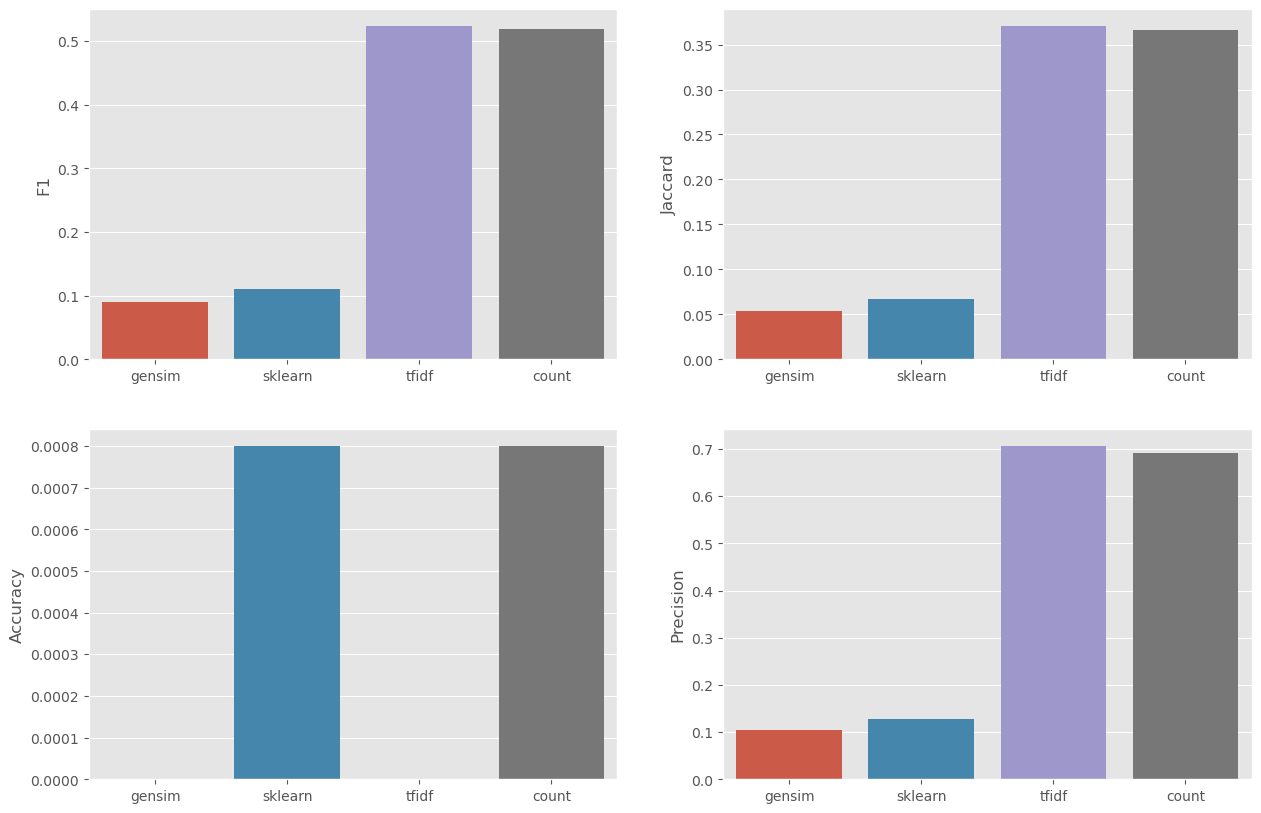

,F1,Jaccard,Accuracy,Precision
gensim,0.090562,0.053621,0.0000,0.104173
sklearn,0.109863,0.067085,0.0008,0.127020
tfidf,0.523879,0.370683,0.0000,0.706527
count,0.518708,0.366259,0.0008,0.691240


In [45]:
evaluate_predictions(true_tags_bin, pred_tags_bin_list, pred_names)

In [46]:
def evaluate_predictions_one_to_one(true_tags, pred_tags_list, pred_names):
    f1_scores = []
    jaccard_scores = []
    accuracy_scores = []
    precision_scores = []
    for pred_tags in pred_tags_list:
        f1_scores.append(f1_score(true_tags, pred_tags, average='samples'))
        jaccard_scores.append(jaccard_score(true_tags, pred_tags, average='samples'))
        accuracy_scores.append(sum([len(set(true_tags[i]).intersection(pred_tags[i]))/len(true_tags[i]) for i in range(len(true_tags))])/len(true_tags))
        precision_scores.append(precision_score(true_tags, pred_tags, average='samples'))
        
    metrics = {"F1": f1_scores, "Jaccard": jaccard_scores, "Accuracy": accuracy_scores, "Precision": precision_scores}
    metrics_df = pd.DataFrame(metrics, index=pred_names)
    
    fig, axes = plt.subplots(2, 2, figsize=(15,10))
    axes = axes.ravel()
    for i, metric in enumerate(metrics.keys()):
        sns.barplot(data=metrics_df, x=metrics_df.index, y=metric, ax=axes[i])
        axes[i].set(ylabel=metric)
    plt.show()
    return metrics_df

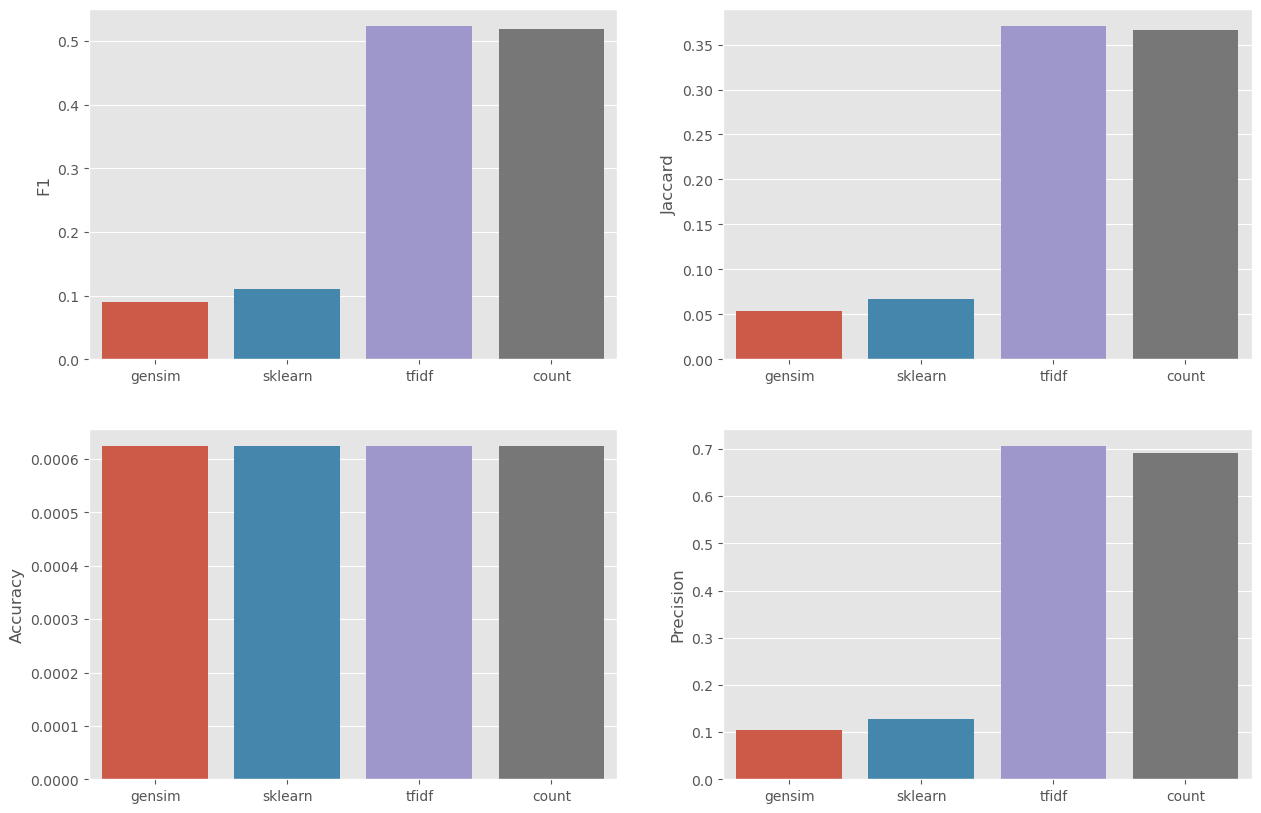

,F1,Jaccard,Accuracy,Precision
gensim,0.090562,0.053621,0.000624,0.104173
sklearn,0.109863,0.067085,0.000624,0.127020
tfidf,0.523879,0.370683,0.000623,0.706527
count,0.518708,0.366259,0.000624,0.691240


In [47]:
evaluate_predictions_one_to_one(true_tags_bin, pred_tags_bin_list, pred_names)

In [48]:
def plot_similar_tags(true_tags, pred_tags, method):
    similar_counts = []
    for pred_tags, true_tags in zip(pred_tags, true_tags):
        similar_words = set(pred_tags) & set(true_tags)
        similar_counts.append(len(similar_words))

    counter = Counter(similar_counts)
    counter = dict(sorted(counter.items()))
    
    # Add missing keys to counter with value 0
    keys = set(range(min(counter.keys()), max(counter.keys()) + 1))
    missing_keys = keys - set(counter.keys())
    for key in missing_keys:
        counter[key] = 0
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f"Similarité des tags avec la méthode {method}", fontsize=18, fontweight='bold', y=1.05)
    axs[0].bar(sorted(counter.keys()), counter.values())
    axs[0].set_xticks(np.arange(min(counter.keys()), max(counter.keys())+1))
    axs[0].set_xticklabels(counter.keys(), rotation=0)
    axs[0].set_xlabel('Nombre de tags similaires', fontsize=14)
    axs[0].set_ylabel("Nombre d'observations", fontsize=14)
    axs[0].set_title("Nombre d'observations avec un\n nombre de tags similaires", fontsize=16)   
    axs[1].pie(counter.values(), labels=counter.keys(), autopct='%1.1f%%', pctdistance=0.8)
    axs[1].legend(title='Tags\nSimilaires', bbox_to_anchor=(1, 0.9), prop={'size': 8},title_fontsize=10)
    axs[1].set_title("Pourcentage d'observations avec \n un nombre de tags similaires", fontsize=16)

    plt.show()

### Dataset de tests

In [49]:
pred_gensim, pred_sklearn, pred_tfidf, pred_count = get_tags_from_text(test_texts_list,
                                                                       test_flat_texts,
                                                                       n_topics,
                                                                       test_vocabulary_texts,
                                                                       min_df,
                                                                       max_df)

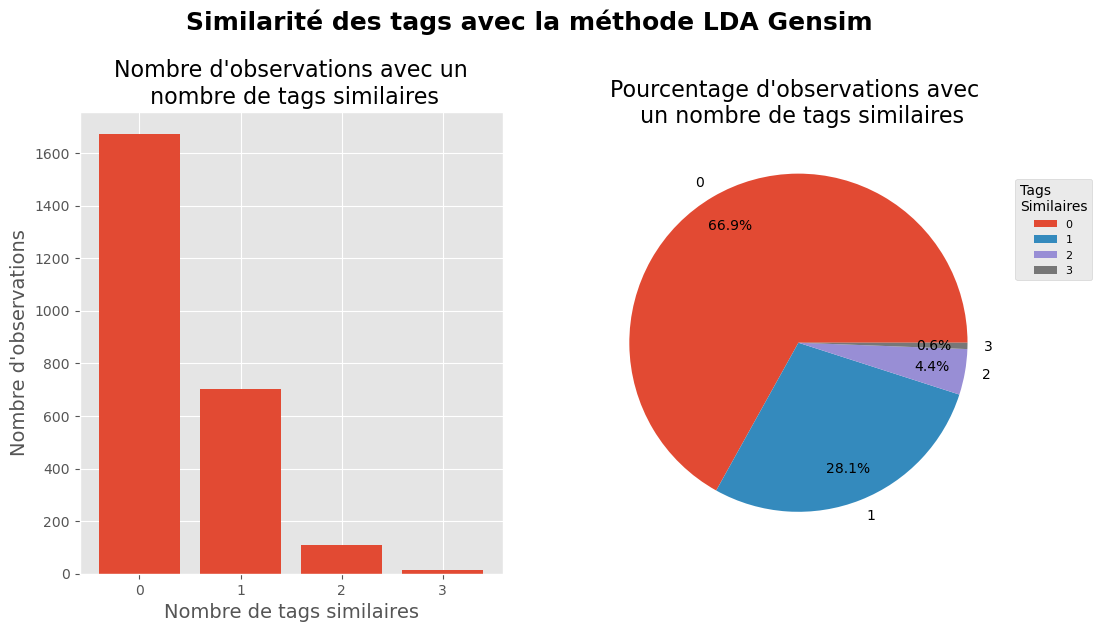

In [50]:
plot_similar_tags(test_tags_list, pred_gensim, 'LDA Gensim')

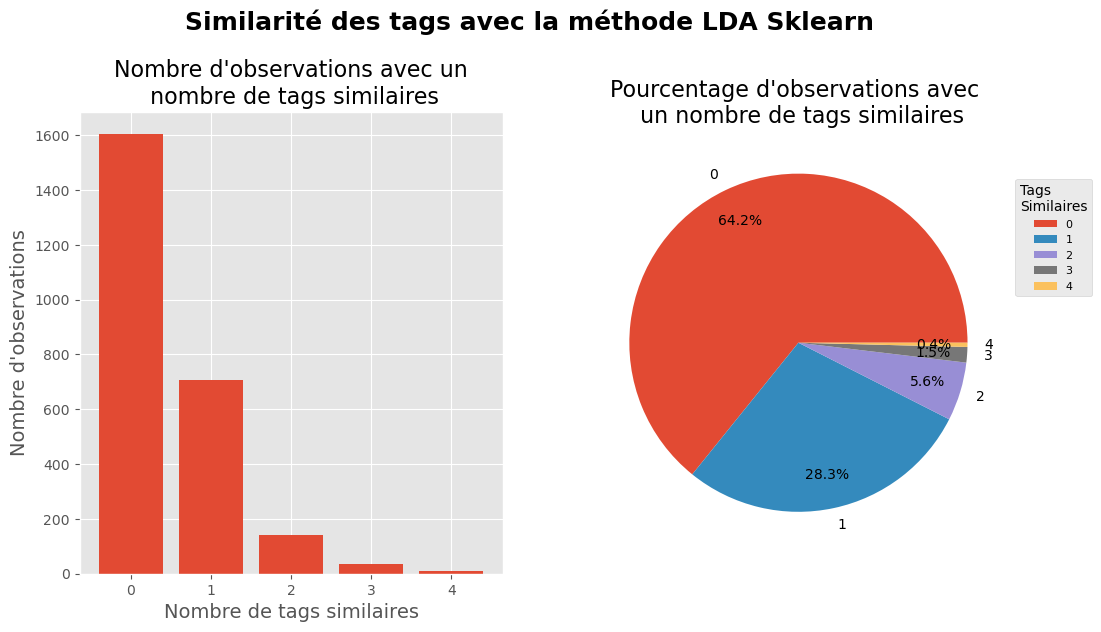

In [51]:
plot_similar_tags(test_tags_list, pred_sklearn, 'LDA Sklearn')

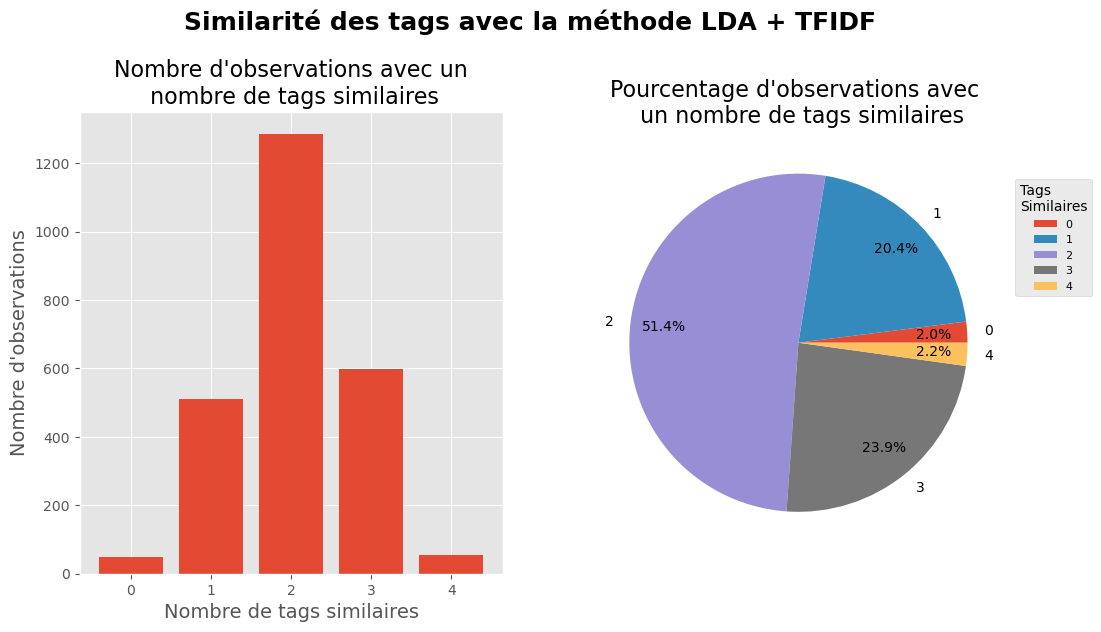

In [52]:
plot_similar_tags(test_tags_list, pred_tfidf, 'LDA + TFIDF')

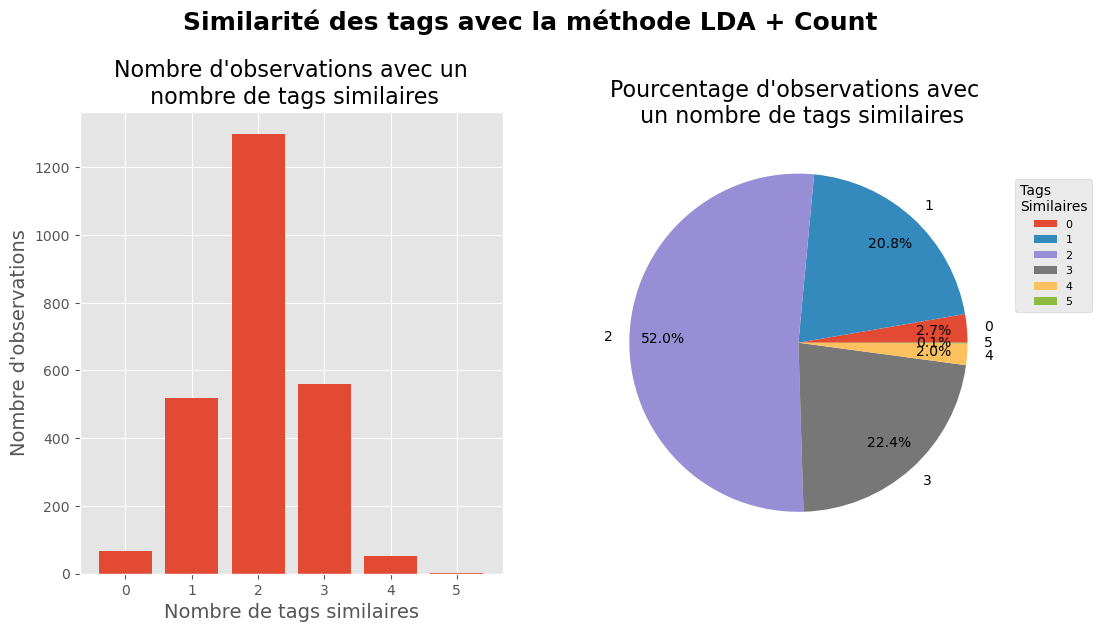

In [53]:
plot_similar_tags(test_tags_list, pred_count, 'LDA + Count')

In [54]:
# AJOUT PCA !

## <font color="#114b98" id="section_3">3. Approche supervisée</font>

### Dataset d'essais

In [55]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

In [56]:
mlb = MultiLabelBinarizer(classes=vocabulary_tags)

In [57]:
tags_mlb = mlb.fit_transform(flat_tags)

In [58]:
classifiers = [LogisticRegression(random_state=42, max_iter=300, tol=1e-5),
               SGDClassifier(random_state=42, max_iter=300, tol=1e-5),
               RandomForestClassifier(random_state=42),
               KNeighborsClassifier(),
               MultinomialNB()]

 - Accuracy: mesure de combien de prédictions faites par le modèle sont correctes
 - Precision: mesure combien des prédictions positives faites par le modèle sont effectivement correctes. Un score de précision élevé signifie que le modèle fait peu de prédictions positives fausses.
 - Recall: mesure combien des exemples positifs réels sont correctement prédits par le modèle. Un score de rappel élevé signifie que le modèle est capable de trouver la plupart des exemples positifs.
 - F1 Score: mesure de l'exactitude d'un modèle, il est un moyen harmonique de précision et de rappel. Il varie de 0 à 1, où un score proche de 1 indique une meilleure performance et un score proche de 0 indique une performance moins bonne. 
 - Jaccard Score: mesure de la similarité entre les deux ensembles de prédictions et de vraies étiquettes. Il varie de 0 à 1, où un score proche de 1 indique une très grande similitude et un score proche de 0 indique une grande dissimilarité.

In [59]:
def calculate_supervised_scores(flat_texts, tags_mlb, vectorizer, classifiers):
    
    # Create an empty dataframe to store the results
    results_df = pd.DataFrame(columns=['Classifier', 'Accuracy', 'Precision', 'Recall',
                                       'F1 Score', 'Jaccard Score', 'Time (s)'])

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(flat_texts, tags_mlb, test_size=0.2, random_state=42)
    
    # Vectorize X_train and X_test
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    
    # Fit an independent model for each class using the OneVsRestClassifier wrapper.
    for classifier in classifiers:
        start_time = time.time()
        ovrc = OneVsRestClassifier(classifier)
        ovrc.fit(X_train, y_train)
        y_pred_ovrc = ovrc.predict(X_test)
        end_time = time.time()
        
        accuracy = round(accuracy_score(y_test, y_pred_ovrc), 4)
        precision = round(precision_score(y_test, y_pred_ovrc, average='samples'), 4)
        recall = round(recall_score(y_test, y_pred_ovrc, average='samples'), 4)
        f1 = round(f1_score(y_test, y_pred_ovrc, average='samples'), 4)
        jaccard = round(jaccard_score(y_test, y_pred_ovrc, average='samples'), 4)
        time_taken = round(end_time - start_time, 4)
        
        results_df = results_df.append({'Classifier': str(classifier).split('(')[0], 
                                       'Accuracy': accuracy, 
                                       'Precision': precision, 
                                       'Recall': recall, 
                                       'F1 Score': f1, 
                                       'Jaccard Score': jaccard,
                                       'Time (s)': time_taken}, 
                                       ignore_index=True)
                                       
        print('Results for classifier:', classifier)
        print("Accuracy : ", accuracy)
        print("Precision : ", precision)
        print("Recall : ", recall)
        print("F1 Score : ", f1)
        print("Jaccard Score:", jaccard)
        print("Time (s):", time_taken)
        print('\n')
        
    return results_df

In [60]:
# Initialize the vectorizer
vectorizer = CountVectorizer()

In [61]:
results_df_CountVectorizer = calculate_supervised_scores(flat_texts,
                                                         tags_mlb,
                                                         vectorizer,
                                                         classifiers)

Results for classifier: LogisticRegression(max_iter=300, random_state=42, tol=1e-05)
Accuracy :  0.626
Precision :  0.821
Recall :  0.853
F1 Score :  0.8133
Jaccard Score: 0.766
Time (s): 0.6872


Results for classifier: SGDClassifier(max_iter=300, random_state=42, tol=1e-05)
Accuracy :  0.556
Precision :  0.783
Recall :  0.764
F1 Score :  0.7487
Jaccard Score: 0.699
Time (s): 0.6576


Results for classifier: RandomForestClassifier(random_state=42)
Accuracy :  0.684
Precision :  0.826
Recall :  0.949
F1 Score :  0.8647
Jaccard Score: 0.819
Time (s): 2.7245


Results for classifier: KNeighborsClassifier()
Accuracy :  0.642
Precision :  0.813
Recall :  0.915
F1 Score :  0.8393
Jaccard Score: 0.79
Time (s): 0.6846


Results for classifier: MultinomialNB()
Accuracy :  0.668
Precision :  0.832
Recall :  0.895
F1 Score :  0.8413
Jaccard Score: 0.797
Time (s): 0.6546




In [62]:
results_df_CountVectorizer

,Classifier,Accuracy,Precision,Recall,F1 Score,Jaccard Score,Time (s)
0,LogisticRegression,0.626,0.821,0.853,0.8133,0.766,0.6872
1,SGDClassifier,0.556,0.783,0.764,0.7487,0.699,0.6576
2,RandomForestClassifier,0.684,0.826,0.949,0.8647,0.819,2.7245
3,KNeighborsClassifier,0.642,0.813,0.915,0.8393,0.790,0.6846
4,MultinomialNB,0.668,0.832,0.895,0.8413,0.797,0.6546


Selon ces résultats, il semble que le RandomForestClassifier a les meilleures performances globales, avec la plus grande précision, rappel et score F1. Le classificateur de régression logistique se comporte également bien, avec une précision légèrement inférieure.

Cependant, le RandomForestClassifier est aussi le seul à nécessiter un temps d'entraînement aussi long.

In [63]:
def plot_results(results_df):
    
    # Create a figure with 5 subplots
    fig, axs = plt.subplots(2, 3, figsize=(20,10))
    # Set a color palette
    my_palette = sns.color_palette("husl", 5)
    
    # Set the x-axis to be a range of numerical values
    x = range(len(results_df))
    scoring_methods = ['Accuracy','Precision','Recall','F1 Score','Jaccard Score', 'Time (s)']
    
    # Create a subplot for each scoring method
    for i, scoring_method in enumerate(scoring_methods):
        sns.barplot(x='Classifier', 
                    y=scoring_method, 
                    data=results_df, 
                    ax=axs[i // 3, i % 3], 
                    palette=my_palette, 
                    label=scoring_method)
    
    # Add classifier names to x-axis
    for i in range(2):
        for j in range(3):
            axs[i,j].set_title(scoring_methods[i*3+j])
            axs[i,j].set_xticks(x)
            axs[i,j].set_xlabel('')
            
            if j == 0:
                axs[i,j].set_ylabel('Score')
            else:
                axs[i,j].set_ylabel('')
            
            if i == 1:
                axs[i,j].set_xticklabels(results_df['Classifier'], rotation=90)
            else:
                axs[i,j].set_xticklabels('')
            
    plt.show()

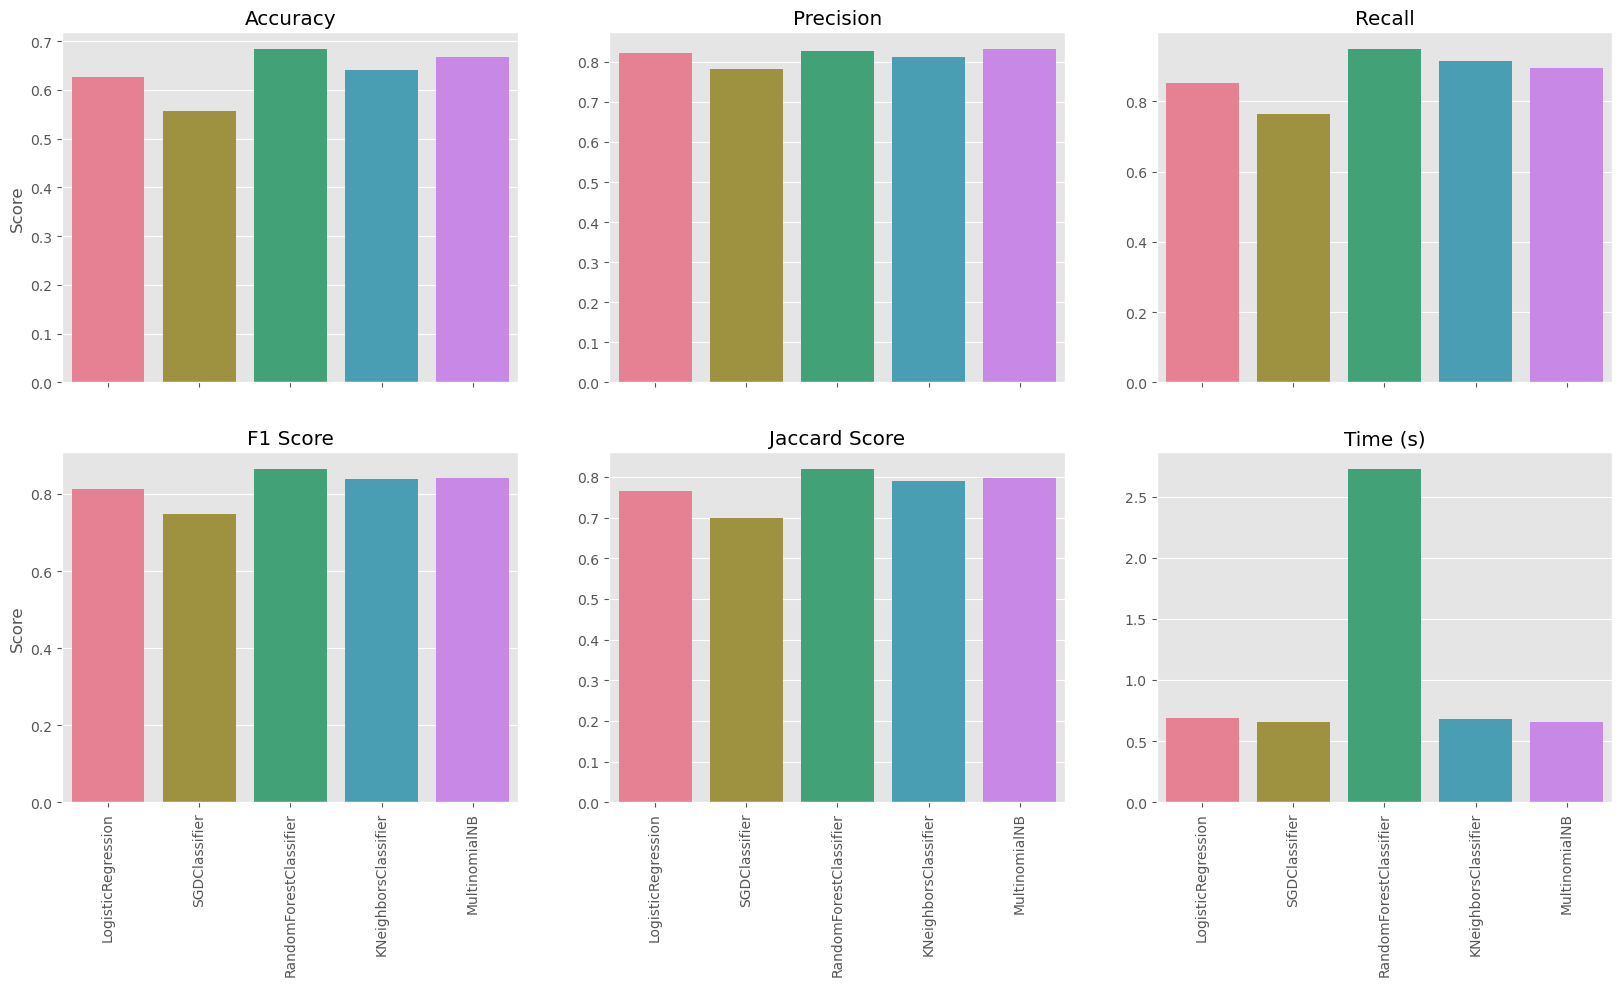

In [64]:
# Call the plot_results function
plot_results(results_df_CountVectorizer)

In [65]:
# Initialize the vectorizer
vectorizer = TfidfVectorizer(vocabulary=vocabulary_texts)

In [66]:
results_df_TfidfVectorizer = calculate_supervised_scores(flat_texts,
                                                         tags_mlb,
                                                         vectorizer,
                                                         classifiers)

Results for classifier: LogisticRegression(max_iter=300, random_state=42, tol=1e-05)
Accuracy :  0.676
Precision :  0.823
Recall :  0.943
F1 Score :  0.86
Jaccard Score: 0.814
Time (s): 0.6766


Results for classifier: SGDClassifier(max_iter=300, random_state=42, tol=1e-05)
Accuracy :  0.556
Precision :  0.789
Recall :  0.746
F1 Score :  0.7427
Jaccard Score: 0.693
Time (s): 0.6616


Results for classifier: RandomForestClassifier(random_state=42)
Accuracy :  0.68
Precision :  0.821
Recall :  0.956
F1 Score :  0.8653
Jaccard Score: 0.819
Time (s): 4.7954


Results for classifier: KNeighborsClassifier()
Accuracy :  0.646
Precision :  0.824
Recall :  0.905
F1 Score :  0.84
Jaccard Score: 0.791
Time (s): 0.8217


Results for classifier: MultinomialNB()
Accuracy :  0.674
Precision :  0.818
Recall :  0.962
F1 Score :  0.866
Jaccard Score: 0.818
Time (s): 0.6466




In [67]:
results_df_TfidfVectorizer

,Classifier,Accuracy,Precision,Recall,F1 Score,Jaccard Score,Time (s)
0,LogisticRegression,0.676,0.823,0.943,0.8600,0.814,0.6766
1,SGDClassifier,0.556,0.789,0.746,0.7427,0.693,0.6616
2,RandomForestClassifier,0.680,0.821,0.956,0.8653,0.819,4.7954
3,KNeighborsClassifier,0.646,0.824,0.905,0.8400,0.791,0.8217
4,MultinomialNB,0.674,0.818,0.962,0.8660,0.818,0.6466


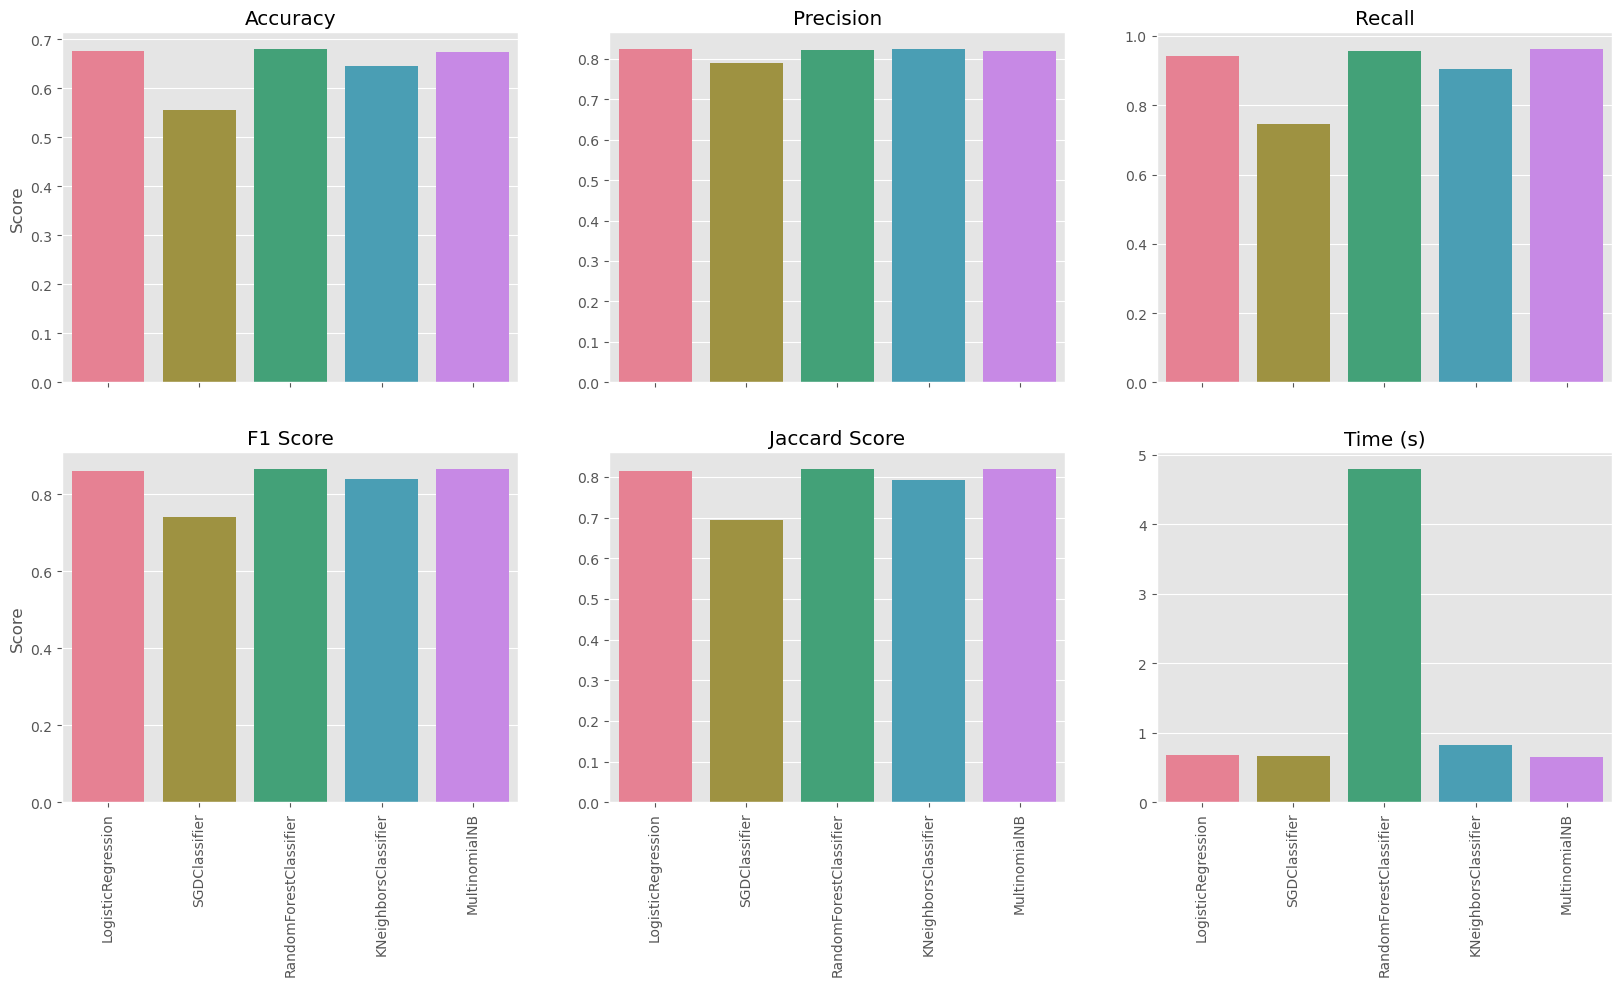

In [68]:
# Call the plot_results function
plot_results(results_df_TfidfVectorizer)

Le RandomForestClassifier obtient les meilleurs scores, peu importe le vectorizer utilisé.

In [69]:
results_RFC = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Jaccard Score'])
results_RFC = results_RFC.append(results_df_CountVectorizer.iloc[2,1:]).reset_index(drop=True)
results_RFC = results_RFC.append(results_df_TfidfVectorizer.iloc[2,1:]).reset_index(drop=True)
results_RFC['Classifier'] = ['CountVectorizer', 'TfidfVectorizer']
results_RFC

,Accuracy,Precision,Recall,F1 Score,Jaccard Score,Time (s),Classifier
0,0.684,0.826,0.949,0.8647,0.819,2.7245,CountVectorizer
1,0.680,0.821,0.956,0.8653,0.819,4.7954,TfidfVectorizer


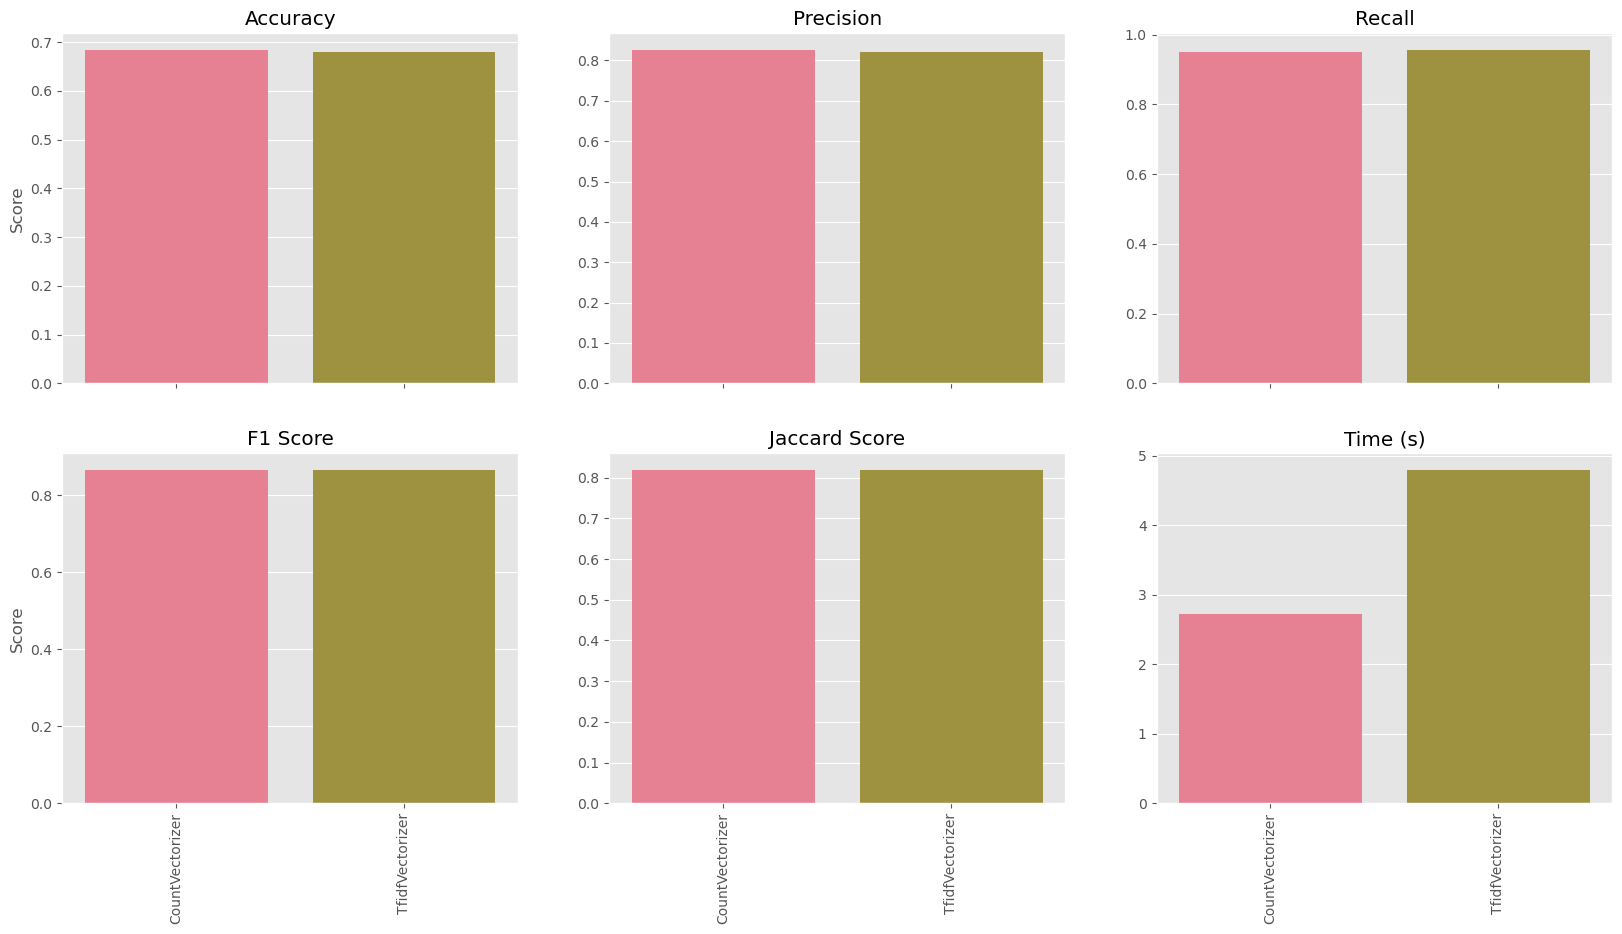

In [70]:
# Call the plot_results function
plot_results(results_RFC)

CountVectorizer permet d'avoir des performances similaires avec un temps d'entraînement plus court que TfidfVectorizer.

### Dataset de tests

## <font color="#114b98" id="section_4">4. Approche supervisée avec Word Embedding : Word2Vec</font>

### Dataset d'essais

In [71]:
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix

In [72]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(texts_list,
                                                    tags_mlb,
                                                    test_size=0.2,
                                                    random_state=42)

In [73]:
# Train the Word2Vec model on your text data
w2v_model = Word2Vec(X_train, vector_size=1000, window=5, min_count=5, workers=4)

In [74]:
# Create a vocabulary of only the words in the text data that are in the word2vec model
vocab = set(w2v_model.wv.key_to_index.keys())

In [75]:
# Filter the text data to only include words in the vocabulary
X_train = [[word for word in sublist if word in vocab] for sublist in X_train]
X_test = [[word for word in sublist if word in vocab] for sublist in X_test]

In [76]:
# Remove any observations that have no words in the vocabulary
train_removed_indexes = []
test_removed_indexes = []
for i, sublist in enumerate(X_train):
    if not any(word in vocab for word in sublist):
        train_removed_indexes.append(i)
for i, sublist in enumerate(X_test):
    if not any(word in vocab for word in sublist):
        test_removed_indexes.append(i)

In [77]:
X_train = [x for i, x in enumerate(X_train) if i not in train_removed_indexes]
X_test = [x for i, x in enumerate(X_test) if i not in test_removed_indexes]
y_train = [x for i, x in enumerate(y_train) if i not in train_removed_indexes]
y_test = [x for i, x in enumerate(y_test) if i not in test_removed_indexes]

In [78]:
# Create embeddings for train and test data
X_train_embedded = [np.mean([w2v_model.wv[word] for word in sentence], axis=0) for sentence in X_train]
X_test_embedded = [np.mean([w2v_model.wv[word] for word in sentence], axis=0) for sentence in X_test]

In [79]:
clf = OneVsRestClassifier(LogisticRegression(random_state=42))

In [80]:
# Fit the classifier on the train data
clf.fit(X_train_embedded, y_train)

OneVsRestClassifier(estimator=LogisticRegression(random_state=42))

In [81]:
# Make predictions on the test data
y_pred = clf.predict(X_test_embedded)

In [82]:
# Calculate scores
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')
jaccard = jaccard_score(y_test, y_pred, average='samples')

# Print the results
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-Score: {:.2f}".format(f1))
print("Jaccard Score: {:.2f}".format(jaccard))

Accuracy: 0.67
Precision: 0.82
Recall: 1.00
F1-Score: 0.90
Jaccard Score: 0.82


In [83]:
classifiers = [LogisticRegression(random_state=42, max_iter=300, tol=1e-5),
               SGDClassifier(random_state=42, max_iter=300, tol=1e-5),
               RandomForestClassifier(random_state=42),
               KNeighborsClassifier()]

In [84]:
def calculate_supervised_word2vec(X_train, X_test, y_train, y_test, classifiers):
    
    # Create an empty dataframe to store the results
    results_df = pd.DataFrame(columns=['Classifier', 'Accuracy', 'Precision', 'Recall',
                                       'F1 Score', 'Jaccard Score', 'Time (s)'])
    
    # Fit an independent model for each class using the OneVsRestClassifier wrapper.
    for clf in classifiers:
        start_time = time.time()
        ovrc = OneVsRestClassifier(clf)
        ovrc.fit(X_train, y_train)
        y_pred_ovrc = ovrc.predict(X_test)
        end_time = time.time()
        
        accuracy = round(accuracy_score(y_test, y_pred_ovrc), 4)
        precision = round(precision_score(y_test, y_pred_ovrc, average='samples'), 4)
        recall = round(recall_score(y_test, y_pred_ovrc, average='samples'), 4)
        f1 = round(f1_score(y_test, y_pred_ovrc, average='samples'), 4)
        jaccard = round(jaccard_score(y_test, y_pred_ovrc, average='samples'), 4)
        time_taken = round(end_time - start_time, 4)
        
        results_df = results_df.append({'Classifier': str(clf).split('(')[0], 
                                       'Accuracy': accuracy, 
                                       'Precision': precision, 
                                       'Recall': recall, 
                                       'F1 Score': f1, 
                                       'Jaccard Score': jaccard,
                                       'Time (s)': time_taken}, 
                                       ignore_index=True)
        
    return results_df

In [85]:
results_df_word2vec = calculate_supervised_word2vec(X_train_embedded,
                                                    X_test_embedded,
                                                    y_train,
                                                    y_test,
                                                    classifiers)

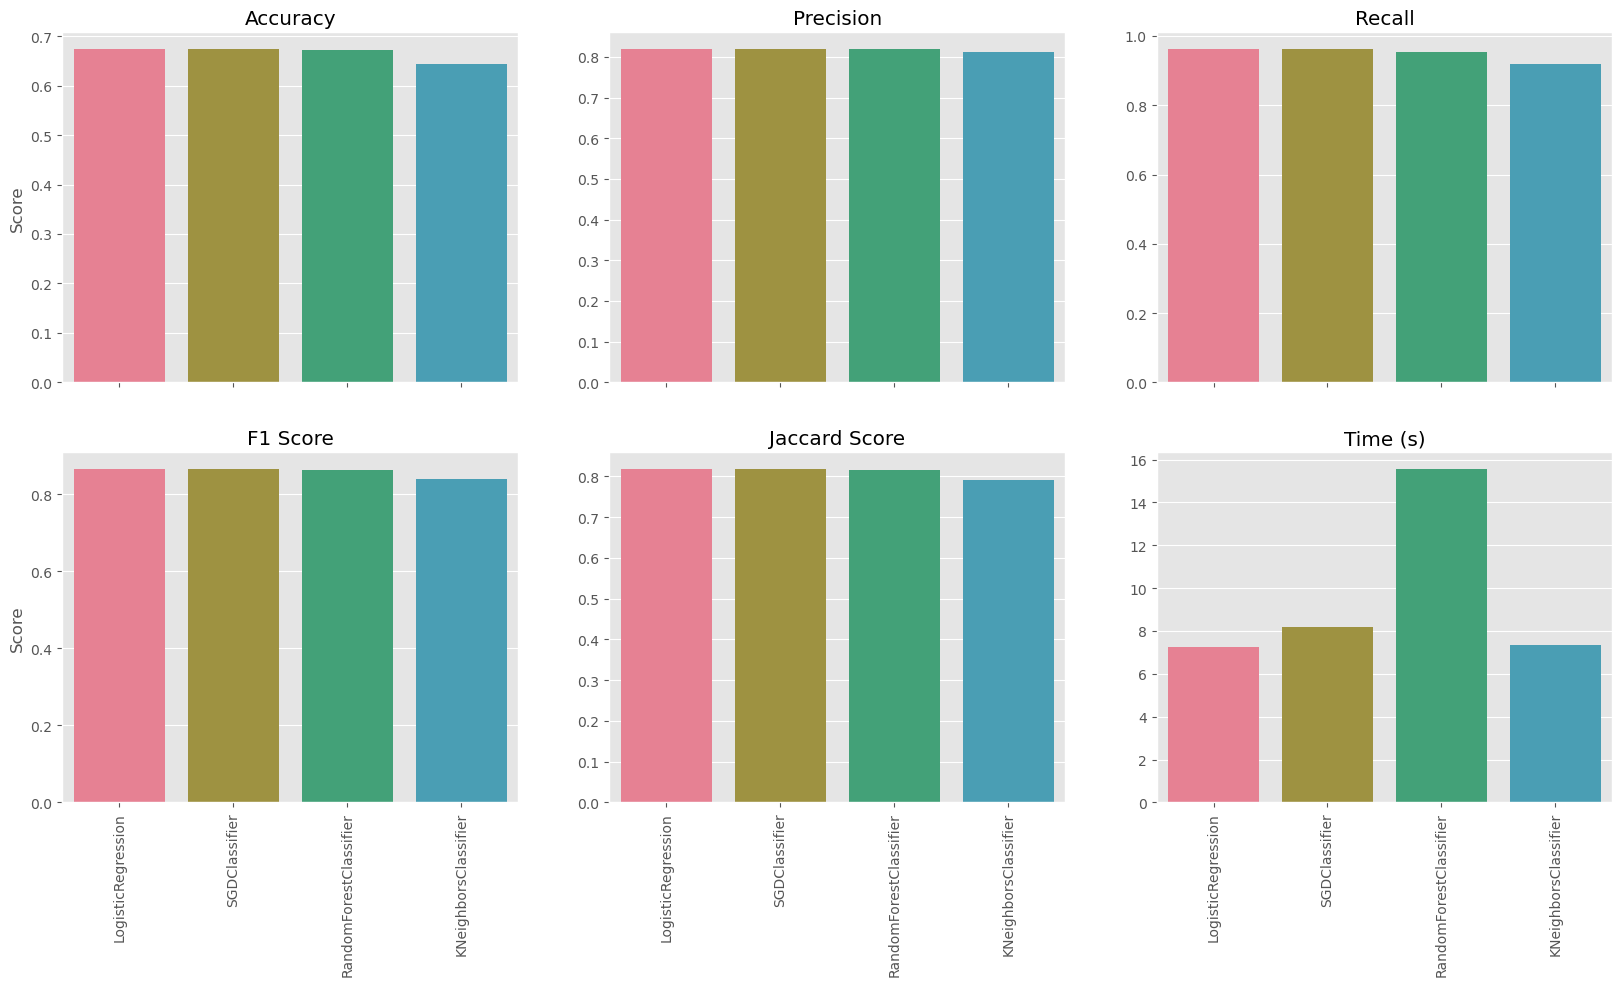

In [86]:
# Call the plot_results function
plot_results(results_df_word2vec)

### Dataset de tests

## <font color="#114b98" id="section_5">5. Approche supervisée avec Word Embedding : BERT</font>

### Dataset d'essais

In [87]:
import torch
import tensorflow_hub as hub
import tensorflow as tf
import transformers
import tokenization
from transformers import BertTokenizer, AutoModel, BertTokenizerFast
from torch.nn import CrossEntropyLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from torch import nn
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from tqdm import tqdm

In [88]:
vocabulary_tags = set([word for word, count in Counter([word for item in tags_list for word in item]).most_common() if count >= 20])

In [89]:
# pip install  torch===1.7.1+cu110 torchvision===0.8.2+cu110 torchaudio===0.7.2 --user -f https://download.pytorch.org/whl/torch_stable.html

In [90]:
texts = train_df['Texts'].copy()
tags = train_df['Tags'].copy()

In [91]:
for i in range(len(texts)):
    texts[i] = " ".join(texts[i])
    tags[i] = " ".join(tags[i])

In [92]:
mlb = MultiLabelBinarizer()
tags_bin = mlb.fit_transform(tags_list)

In [93]:
train_text, test_text, train_labels, test_labels = train_test_split(texts, 
                                                                    tags_bin, 
                                                                    test_size=0.2, 
                                                                    random_state=42)

In [94]:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [95]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [96]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocab_file, do_lower_case)

In [97]:
tokens_train = bert_encode(train_text.values, tokenizer, max_len=100)
tokens_test = bert_encode(test_text.values, tokenizer, max_len=100)

In [98]:
tokenizer

PreTrainedTokenizer(name_or_path='', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [99]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    out = Dense(len(train_labels[0]), activation='sigmoid')(clf_output)    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['binary_accuracy'])
    
    return model

In [100]:
model = build_model(bert_layer, max_len=100)

In [101]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

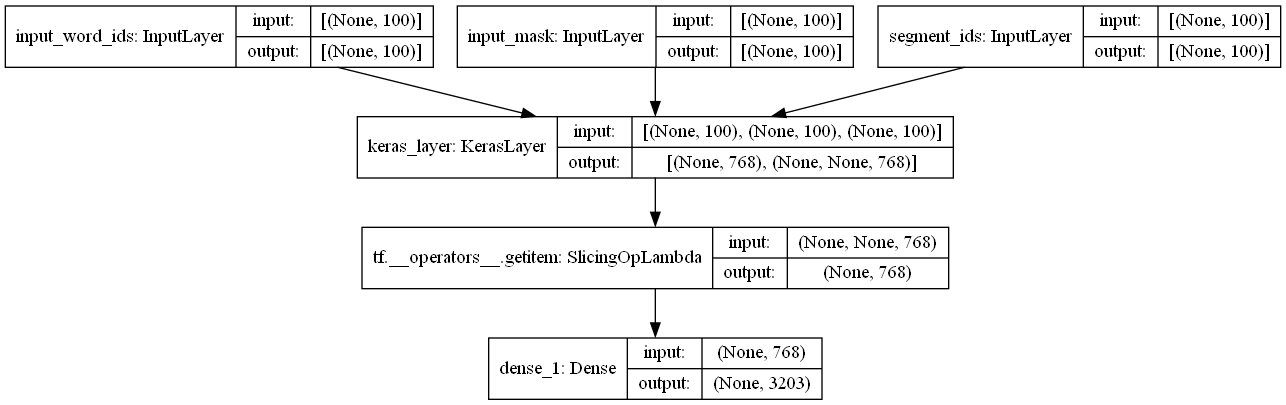

In [102]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [103]:
# use one-hot encoded labels for training
train_history = model.fit(
    tokens_train, train_labels,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
)

Epoch 1/10
50/50 [==============================] - 29s 404ms/step - loss: 0.6888 - binary_accuracy: 0.5423 - val_loss: 0.6653 - val_binary_accuracy: 0.6018
Epoch 2/10
50/50 [==============================] - 19s 389ms/step - loss: 0.6397 - binary_accuracy: 0.6517 - val_loss: 0.6157 - val_binary_accuracy: 0.6997
Epoch 3/10
50/50 [==============================] - 19s 387ms/step - loss: 0.5976 - binary_accuracy: 0.7354 - val_loss: 0.5809 - val_binary_accuracy: 0.7679
Epoch 4/10
50/50 [==============================] - 19s 387ms/step - loss: 0.5676 - binary_accuracy: 0.7923 - val_loss: 0.5548 - val_binary_accuracy: 0.8141
Epoch 5/10
50/50 [==============================] - 19s 387ms/step - loss: 0.5438 - binary_accuracy: 0.8335 - val_loss: 0.5330 - val_binary_accuracy: 0.8523
Epoch 6/10
50/50 [==============================] - 19s 387ms/step - loss: 0.5231 - binary_accuracy: 0.8679 - val_loss: 0.5132 - val_binary_accuracy: 0.8828
Epoch 7/10
50/50 [==============================] - 19s 38

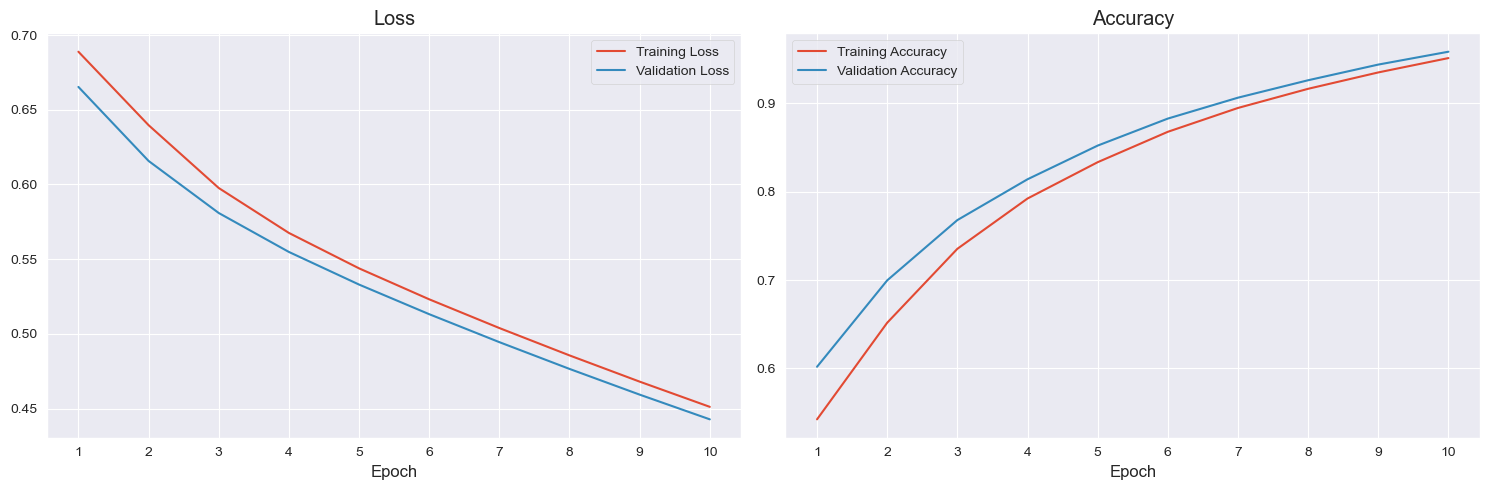

In [104]:
sns.set_style("darkgrid")

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(x=np.arange(1,11), y=train_history.history['loss'], label="Training Loss", ax=axs[0])
sns.lineplot(x=np.arange(1,11), y=train_history.history['val_loss'], label="Validation Loss", ax=axs[0])
axs[0].set_title("Loss")
axs[0].set_xticks(np.arange(1,11))
axs[0].set_xlabel("Epoch")

sns.lineplot(x=np.arange(1,11), y=train_history.history['binary_accuracy'], label="Training Accuracy", ax=axs[1])
sns.lineplot(x=np.arange(1,11), y=train_history.history['val_binary_accuracy'], label="Validation Accuracy", ax=axs[1])
axs[1].set_title("Accuracy")
axs[1].set_xticks(np.arange(1,11))
axs[1].set_xlabel("Epoch")

plt.tight_layout()
plt.show()

In [105]:
model.evaluate(tokens_test, test_labels)

16/16 [==============================] - 2s 125ms/step - loss: 0.4428 - binary_accuracy: 0.9586


[0.44278034567832947, 0.9585632085800171]

In [106]:
predictions = []

for text in tqdm(flat_texts):
    preds = model.predict(bert_encode(text, tokenizer, max_len=100))
    indices = np.argsort(preds)[0][-5:]
    preds[0, indices] = 1
    preds[np.where(preds != 1)] = 0
    decoded = mlb.inverse_transform(preds)
    predictions.append(decoded[0])

100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [17:28<00:00,  2.38it/s]


In [107]:
predictions[0:5]

[('memory-management', 'search-engine', 'tar', 'textbox', 'tintcolor'),
 ('memory-management', 'search-engine', 'tar', 'textbox', 'tintcolor'),
 ('cart', 'fadeout', 'system-calls', 'textbox', 'translation'),
 ('cart', 'fadeout', 'system-calls', 'textbox', 'translation'),
 ('cart', 'fadeout', 'layout', 'system-calls', 'textbox')]

In [108]:
def convert_tags(row):
    tags = row.split()
    tags = [f"'{tag}'" for tag in tags]
    return tuple(tags)

converted_tags = tags.apply(convert_tags)

In [109]:
converted_tags

0       ('ios', 'xcode', 'flutter', 'build', 'simulator')
1       ('haskell', 'recursion', 'ocaml', 'sml', 'fixp...
2       ('java', 'file', 'jar', 'copy', 'working-direc...
3                ('java', 'html', 'xhtml', 'docx', 'doc')
4       ('iphone', 'ios', 'objective-c', 'keyboard', '...
                              ...                        
2495    ('haskell', 'concurrency', 'parallel-processin...
2496    ('javascript', 'html', 'css', 'server', 'local...
2497       ('git', 'merge', 'diff', 'config', 'conflict')
2498    ('java', 'networking', 'jdbc', 'tcp', 'connect...
2499    ('string', 'macros', 'lambda', 'scheme', 'expr...
Name: Tags, Length: 2500, dtype: object

In [110]:
# parsed_true_tags = [ast.literal_eval(tag[1:-1]) for tag in tags.to_list()]

In [111]:
# parsed_true_tags[0:5]

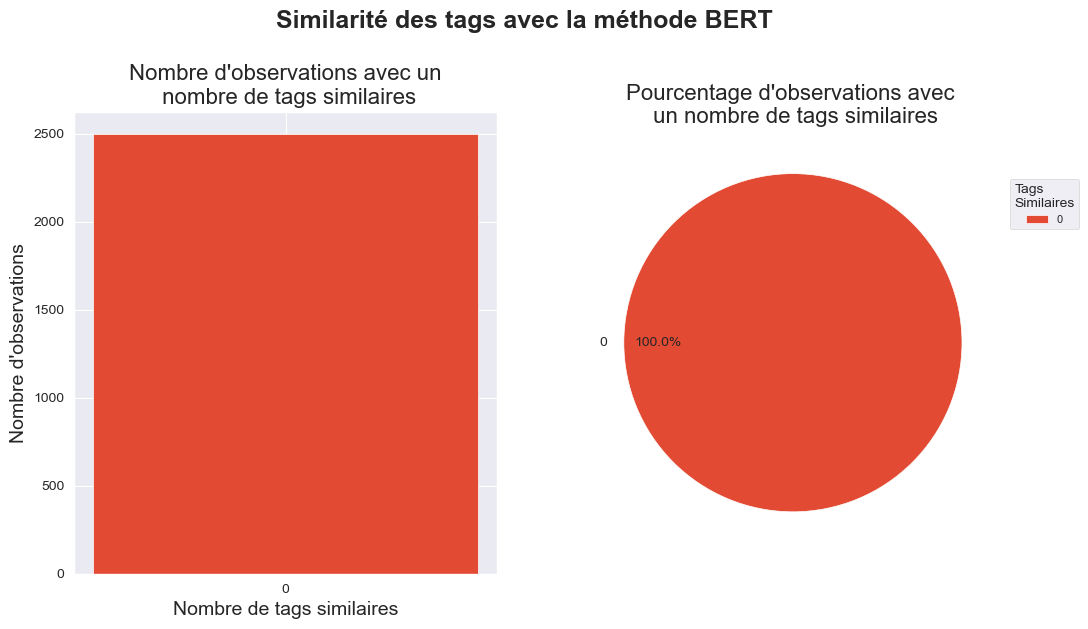

In [112]:
plot_similar_tags(converted_tags, predictions, 'BERT')

### Dataset de tests

## <font color="#114b98" id="section_6">6. Approche supervisée avec Sentence Embedding : USE</font>

### Dataset d'essais

In [113]:
from rake_nltk import Rake
# from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
import ast

In [114]:
data_use = pd.read_csv(main_path+'saved_ressources/'+'data_cleaned_wo_tokenizer.csv', encoding='utf8')

In [115]:
sentences = data_use['Texts'].to_list()
tags = data_use['Tags'].to_list()

In [116]:
extracted_sentences = [sentences[i] for i in train_indexes]
extracted_tags = [tags[i] for i in train_indexes]
parsed_true_tags = [ast.literal_eval(tags[1:-1]) for tags in extracted_tags]

In [117]:
def extract_keywords(input_text):
    # Load the USE model
    model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
    all_keywords = []
    # Encode all the sentences in the input text
    embeddings = model(input_text)
    # Compute the cosine similarity between all the sentences
    similarity_matrix = cosine_similarity(embeddings)
    # Iterate over the list of sentences
    for i in range(len(input_text)):
        # Find the most similar sentences
        most_similar = np.argsort(-similarity_matrix[i])[1:6]
        # Combine the most similar sentences with the current sentence
        text = ' '.join([input_text[j] for j in most_similar])
        # Extract the keywords from the combined text using RAKE
        keyword_extractor = Rake()
        keyword_extractor.extract_keywords_from_text(text)
        word_degrees = keyword_extractor.get_word_degrees()
        sorted_word_degrees = sorted(word_degrees.items(), key=lambda x: x[1], reverse=True)
        keywords = [word for word, degree in sorted_word_degrees[:5]]
        all_keywords.append(keywords)
    return all_keywords

In [118]:
keywords = extract_keywords(extracted_sentences)

In [119]:
keywords[0:5]

[['php', 'index', 'app', 'com', 'public'],
 ['configuration', 'name', 'blah', 'mycustomsection', 'version'],
 ['java', 'cache', 'would', 'compiler', 'code'],
 ['field', 'something', 'public', 'title', 'getsomethingelse'],
 ['aspectj', 'private', 'context', 'email', 'dtd']]

In [120]:
parsed_true_converted_tags = [list(tag) for tag in parsed_true_tags]

In [121]:
parsed_true_converted_tags[0:5]

[['php', 'apache', 'include', 'subdomain', 'server-side-includes'],
 ['c#', '.net', 'asp.net', 'configurationmanager', 'webconfigurationmanager'],
 ['java', 'jvm', 'benchmarking', 'jvm-hotspot', 'microbenchmark'],
 ['java', 'class', 'reflection', 'field', 'private'],
 ['spring', 'annotations', 'aop', 'spring-aop', 'configurable']]

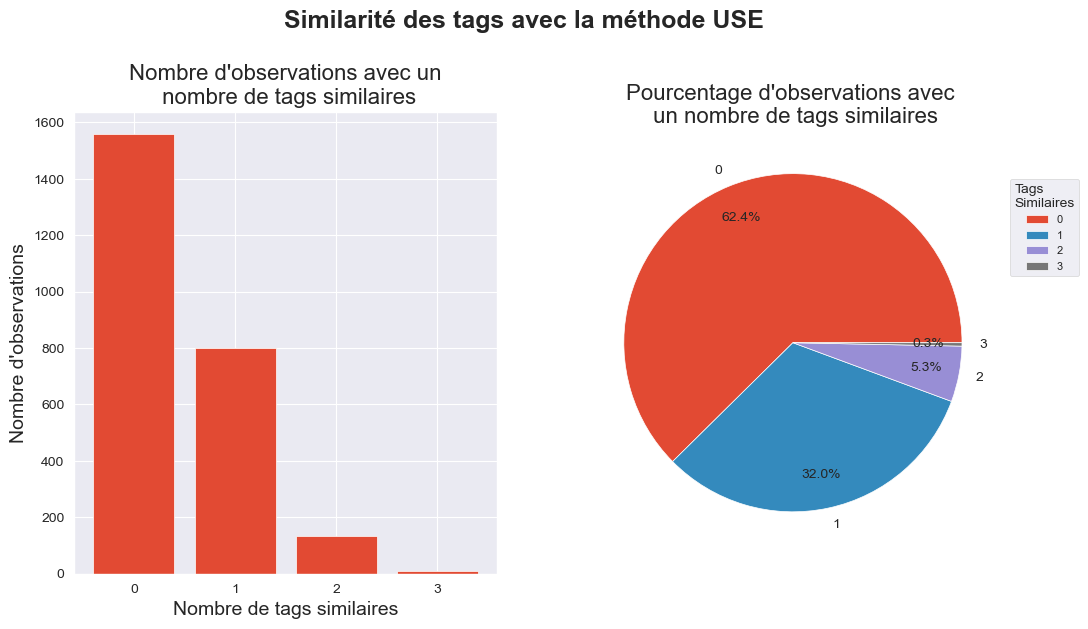

In [122]:
plot_similar_tags(parsed_true_converted_tags, keywords, 'USE')

### Dataset de tests

In [123]:
test_extracted_sentences = [sentences[i] for i in test_indexes]
test_extracted_tags = [tags[i] for i in test_indexes]
test_parsed_true_tags = [ast.literal_eval(tags[1:-1]) for tags in test_extracted_tags]
test_keywords = extract_keywords(test_extracted_sentences)
test_parsed_true_converted_tags = [list(tag) for tag in test_parsed_true_tags]

In [124]:
test_keywords[0:5]

[['application', 'service', 'windows', 'would', 'process'],
 ['web', 'axis', 'application', 'java', 'framework'],
 ['firebug', 'javascript', 'files', 'bound', 'edit'],
 ['startupinfo', 'subprocess', 'command', 'proc', 'popen'],
 ['subnode', 'xml', 'node', 'array', 'xmldoc']]

In [125]:
test_parsed_true_converted_tags[0:5]

[['c#', '.net', 'linux', '.net-2.0', 'mono'],
 ['java', 'jakarta-ee', 'captcha', 'recaptcha', 'simplecaptcha'],
 ['javascript', 'code-formatting', 'minify', 'compression', 'unminify'],
 ['python', 'process', 'arguments', 'hide', 'ps'],
 ['php', 'xml', 'parsing', 'simplexml', 'domdocument']]

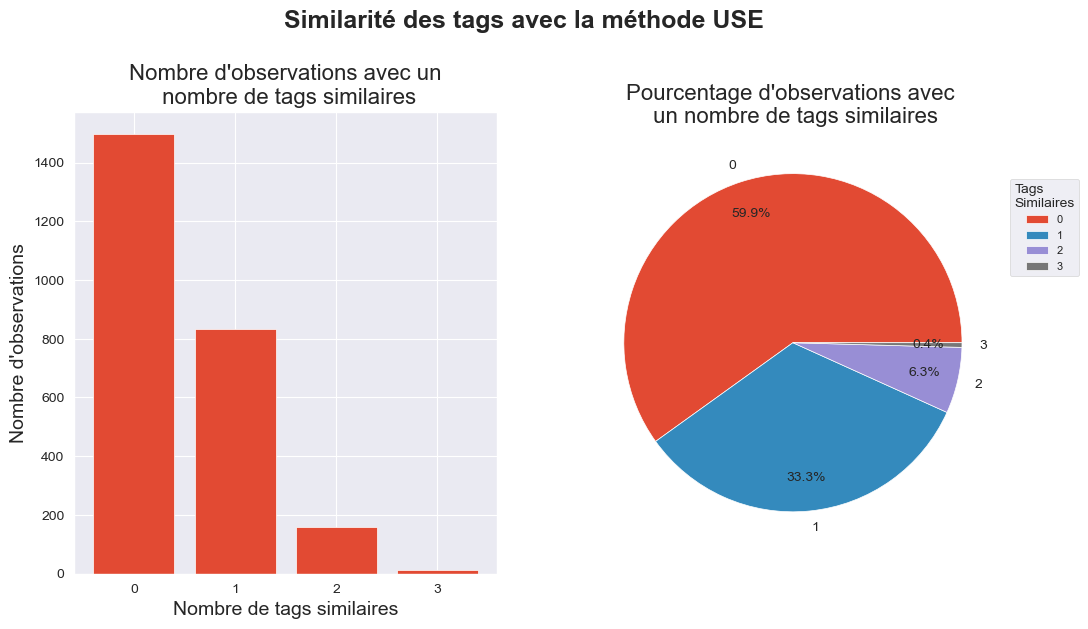

In [126]:
plot_similar_tags(test_parsed_true_converted_tags, test_keywords, 'USE')

## <font color="#114b98" id="section_7">7. Choix du modèle pour le code final à déployer</font>

Nous allons maintenant comparer les différents modèles à l'aide de leurs résultats sur le dataset de tests.